### Sample UseCase to send RHESSI limb flare to JHV
S. Laube, FHNW

This is a demo for the [samp4jhv package](https://github.com/Helioviewer-Project/samp4jhv). JHV stands for JHelioviewer, SAMP is a mechanism to transfer data from an application to another.

The demo requires the following packages:
- astropy 4.1+
- sunpy 2.0+  
- sunkit-instruments 0.2+  
- pyvo  


 **Also, make sure you are running JHelioviewer 4.0 or higher - the app has to be open during execution of this script**

In [1]:
%cd ../..
# use magic jupyter command to move to root directory of the samp4jhv module

import pyvo
from sunkit_instruments.rhessi import imagecube2map # requires sunkit-instruments v0.2
from samp4jhv import SAMP4JHVClient

C:\Projects\JHV\Python\samp4jhv


In [2]:
serv = pyvo.dal.TAPService("https://tap.cs.technik.fhnw.ch/tap")
r = serv.run_sync("SELECT * FROM rhessi_flares.epn_core WHERE granule_uid LIKE '%_clean' and limb_flare = 'True'")
r

<Table length=114>
 granule_uid                 granule_gid               ... goes_class limb_flare
                                                       ...                      
    object                      object                 ...   object      bool   
-------------- --------------------------------------- ... ---------- ----------
 2030712_clean RHESSI flare image reconstruction CLEAN ...       C2.5       True
 2032819_clean RHESSI flare image reconstruction CLEAN ...       C7.6       True
 2040411_clean RHESSI flare image reconstruction CLEAN ...       M1.4       True
 2040413_clean RHESSI flare image reconstruction CLEAN ...       M6.1       True
 2041871_clean RHESSI flare image reconstruction CLEAN ...      C9.4*       True
 2042204_clean RHESSI flare image reconstruction CLEAN ...       C2.8       True
 2042985_clean RHESSI flare image reconstruction CLEAN ...       C2.2       True
 2043001_clean RHESSI flare image reconstruction CLEAN ...       C7.8       True
 2043004_

In [3]:
thumbs_url = r[-1]["thumbnail_url"].decode("utf8") if type(r[-1]["thumbnail_url"]) == bytes else r[-1]["thumbnail_url"]
url = r[-1]["access_url"].decode("utf8") if type(r[-1]["access_url"]) == bytes else r[-1]["access_url"]

print("preview:", thumbs_url)
print("FITS-access:", url)

preview: https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/2015/12/20/20151220_2228_2248/CLEAN/hsi_image_panels_scaled_20151220_2228_2248_13tx3e.jpeg
FITS-access: https://hesperia.gsfc.nasa.gov/rhessi_extras/imagecube_fits/2015/12/20/20151220_2228_2248/hsi_imagecube_clean_20151220_2228_13tx3e.fits


In [4]:
maps = imagecube2map(url)  # sunpy 3.0.1 has a bug where read_file fails with URLs on Windows. Downgrade to 3.0.0

In [5]:
# OPTIONAL: omit JHV gamma correction by saving values as bytes
from sunpy.map import Map
for eb in maps.keys():
    for i in range(len(maps[eb])):
        dmin = maps[eb][i].fits_header['DATAMIN']
        dmax = maps[eb][i].fits_header['DATAMAX']
        if dmax == 0:
            maps[eb][i]._data = maps[eb][i].data.astype('uint8')
        else:
            maps[eb][i]._data = ((maps[eb][i].data.clip(dmin, dmax) - dmin) / dmax * 255).astype('uint8')

In [6]:
# send map layers via SAMP to JHV - make sure JHV > 2.16 is running
c = SAMP4JHVClient()
for energy_band in maps.keys():
    c.send_image_maps(maps[energy_band])

Set MJD-OBS to 57376.943208 from DATE-OBS'. [astropy.wcs.wcs]
C:\Users\Silvan\Anaconda3\envs\py39\lib\site-packages\sunpy\util\decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


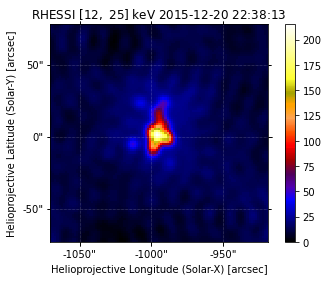

In [7]:
# (optional) preview example map
import matplotlib.pyplot as plt
plt.figure()
maps['12-25 keV'][6].plot(cmap="std_gamma_2")
plt.colorbar()
plt.show()

In [8]:
c.remove_tmp_files()  # (optional) cleanup when done -- after this the images might not display correctly in JHV!